## Entrega Tarea 2 
# Higgs Challenge

### Aaron Vargas
### 201773076-5

In [46]:
import numpy as np
import pandas as pd
import seaborn as sn

In [75]:
random_state=45

# Descripción de datos

## Carga de datos

In [156]:
higgs_feat_file = 'Higgs_features.csv'
higgs_labels_file = 'Higgs_labels.csv'

def parms(labels=False):
    # Parámetros en común para ambos read_csv que no quiero repetir
    return {
        # Carga de datos con C++, y tipo de datos de pyarrow + eficientes - memoria - tiempo
        'engine': 'pyarrow', 
        'dtype_backend': 'pyarrow',
        # Nombre de las columnas porque no vienen
        'names': [ f'feat_{i}' for i in range(8) ] if not labels else ['Highs'] ,
        }

# * desempaquetado, ** desempaquetado parcial
higgs_features = pd.read_csv(higgs_feat_file, **parms() )
higgs_labels = pd.read_csv(higgs_labels_file, **parms(True) )

## Instancias y características

### Features

In [157]:
higgs_features.head()

,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7
0,393.335,79.46,308.879,4.095,1.403,-1.411,49.063,39.478
1,71.048,29.291,55.602,2.439,1.667,-1.412,22.926,9.486
2,141.45,87.017,72.091,1.472,4.714,1.233,23.591,69.754
3,156.539,39.797,127.933,4.017,1.279,-1.408,21.415,18.222
4,89.639,34.399,66.741,2.934,1.417,-1.377,26.459,8.257


In [158]:
higgs_features.describe()

,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7
count,25000.0,25000.0,25000.0,25000.0,25000.0,25000.0,25000.0,25000.0
mean,-48.086665,49.138061,80.961395,2.371241,1.438941,-0.120674,38.688834,41.807678
std,404.976294,35.10046,39.852463,0.781237,0.846006,1.191625,22.446069,32.431353
min,-999.0,0.005,9.495,0.313,0.077,-1.414,20.0,0.346
25%,78.321,19.2605,59.251,1.801,0.878,-1.368,24.5835,21.447
50%,104.802,46.791,73.521,2.49,1.279,-0.312,31.776,34.841
75%,130.04525,73.27525,92.0545,2.961,1.776,1.229,44.956,51.75525
max,835.25,595.819,640.039,5.655,13.137,1.414,381.629,551.06


<Axes: ylabel='Frequency'>

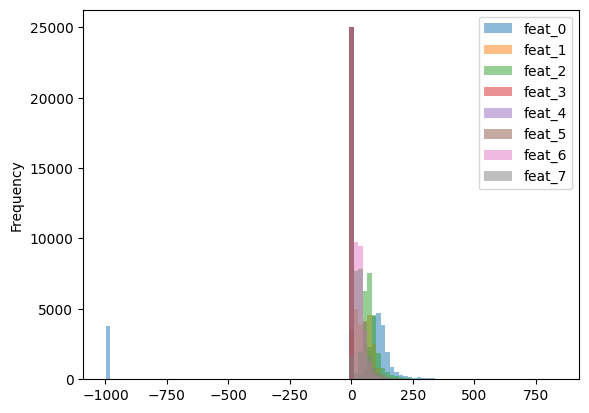

In [159]:
higgs_features.plot.hist(alpha=0.5, bins=100 )

Se observa dos cosas inusuales
1) Hay valores negativos en -1000. En la competencia en Kaggle se indica que se dan valores de -999 a datos sin sentido o que no pudieron ser computados. Se observa que corresponde principalmente a los valores de la `feat_0`
2) Hay muchos valores en 0. Complementando con la información de `.describe()` no hay valores de 0 para la mayoría de las features, solo muy cercanos. Para la `feat_5` ronda en valores desde -1.4 a 1.4 el cual podría explicar que hayan tantos valores en cercanos a cero. Por lo que se concluye que no es un problema.

### Labels

In [160]:
higgs_labels.value_counts()

Highs
0        16526
1         8474
Name: count, dtype: int64

Se ve claramente que los datos se encuentran **desbalanceados**

La clase `0` tiene el **doble** de datos que la clase `1`. Se considera
- Clase **positiva**: label `1` ya que corresponde al si es un boson de higgs
- Clase **negativa**: label `0`

Diagrama para determinar metrica:

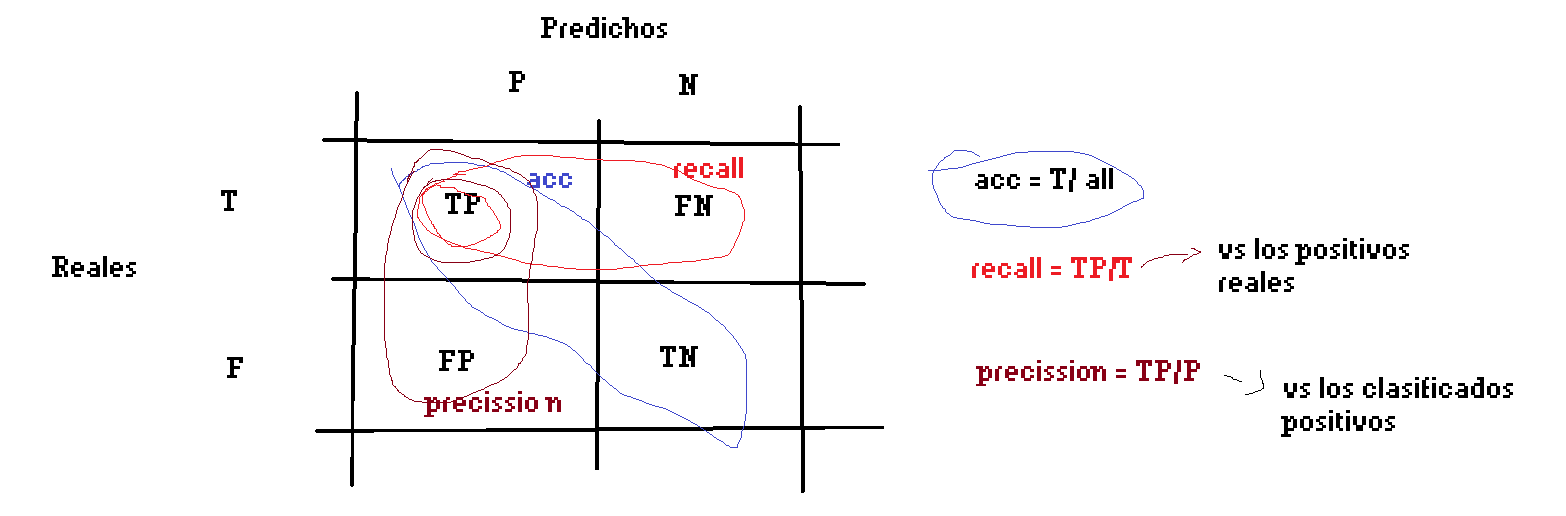

Se elige la métrica $\operatorname{F_{\beta}-Score}$, y `Recall` entre las métricas de ``{accuracy, recall, y precisión}``. La razón del por qué:

- Se **descarta** ``accuracy``, ya que este simplemente busca aumentar tanto los aciertos para la **clase positiva TP y la clase negativa**, pero los datos están desbalanceados, por lo que habrá un **sesgo para la clase negativa**
- Usar cualquiera de las dos métricas, `recall` y `precission` es buena idea, ya que estos **priorizan la clase positiva TP**  sobre la clase negativa. Sin embargo, hay diferencias leves según interés.

- **Precission**, disminuye los **False Positives**, y **recall** disminuye los **False Negative**. 
- Si queremos asegurarnos de cuando el modelo dice _"esta instancia es de la clase positiva"_ sea **cierto** debemos usar `precission`, maximiza la clase negativa (-FP) y se pueden perder instancias Positivas clasificados como False (+FN)
- Si queremos que asegurarnos de que cuando el modelo dice *"esta instancia es clase negativa"* sea **cierto** debemos elegir `recall`, maximiza la clase positiva (-FN) y se pierden instancias Negativos clasificados como True o Positivas (+FP)

En el paper del challenge explica que los casos reales son mucho más desbalanceados de lo que están ahora las instancias. Esto puede provocar que el modelo puesta en marcha con instancias reales **aumente los FN y los FP**. 

Como queremos conservar la mayor cantidad de *TP* que elegimos la métrica ``recall``, ya que esta rescata la mayor cantidad de instancias Positivas (+TP y -FN, ya que el total de instancias Positivas son TP+FN). Sin embargo, no nos interesa clasificar mal instancias Negativas, a demás de que el se verá reducido los casos de interés y se podrá revisar incluso manualmente, sin embargo, si se maximizara la precisión, se perderían una mayor cantidad de casos positivos entre la gran catidad de instancias de la clase Negativa lo que haría imposible una verifiacción manual y se perdería el objetivo de realizar un modelo

¿Por qué no ``F-Score``? F-Score tiene la ventaja que trata de minimizar FP como FN, pero le da la misma cantidad de importancia. Según lo señalado en el contexto anterior, el `recall` es más ``importante`` que precision. Esto se arregla con un $\operatorname{F_{\beta}-{\text{Score}}}$ donde $\beta$ representa cuánto más importante es el recall frente a precision.

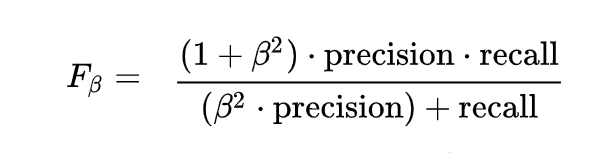

# Árbol de decisión

¿Por qué usar `stratifiedkfold`?

R: Porque las clases están desbalanceadas, así cada fold tiene la misma proporción de de datos por clases de los datos originales cargados. Esto hace que el entrenmiento sea más confiable y los resultados de las métricas sean representativas para la clase original.

In [183]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict, train_test_split
from sklearn.metrics import fbeta_score, make_scorer, ConfusionMatrixDisplay, confusion_matrix

In [162]:
# No se necesita hacer esto porque cross_val_predict devuelve predicciones
# hecha por un modelo-k que nunca se entrenó con ese tramo de datos
# entonces la predicción del tramo k lo hace un modelo distinto cada vez
# x_train, x_val, y_train, y_val = train_test_split(
#     higgs_features,
#     higgs_labels,
#     test_size=0.2
# )

In [ ]:
# el scorer mecionado antes para priorizar recall
fbeta_scorer = make_scorer(
    fbeta_score, 
    # parametros de fbeta_score
    beta=2,
    average='binary'
)

In [164]:
tree = DecisionTreeClassifier(
    random_state=random_state,
    criterion='gini',
    splitter='best',
    max_depth=20,
    class_weight={0: 1, 1: 2}
)

In [184]:
kfold_estrategia = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=random_state
)

fbeta_scores = cross_val_score(
    estimator= tree,
    X= higgs_features,
    y= higgs_labels,
    cv=kfold_estrategia,
    scoring=fbeta_scorer,
)
fbeta_scores

array([0.6661251 , 0.66264354, 0.65541327, 0.67875951, 0.65674463])

In [185]:
print(f'mean: {fbeta_scores.mean()}\nstd: {fbeta_scores.std()}')

mean: 0.6639372100615646
std: 0.008373192672468131


Se reporta que el modelo tiene en promedio un 0.66 de `fbeta_score` con una desviación estandar de $\pm 0.008$. Esto indica que los 5 modelos mas o menos dieron el mismo resultado con cada fold, y no hay diferencias negativas, así que es representativo

In [186]:

pred = cross_val_predict(
    estimator=tree,
    X=higgs_features,
    y=higgs_labels,
    cv=kfold_estrategia,
)
pred

array([0., 1., 1., ..., 0., 0., 0.], shape=(25000,))

In [206]:
def plot_confusion(pred, trues):
    confusion = confusion_matrix(y_pred=pred, y_true=trues )
    ConfusionMatrixDisplay.from_predictions(
        y_true=trues,
        y_pred=pred,
        labels=[1,0]
    )

    return confusion

[[13347  3179]
 [ 2797  5677]]


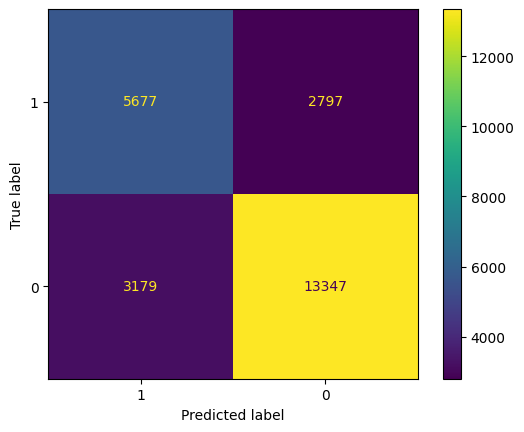

In [208]:
tree_confusion = plot_confusion(pred=pred, trues=higgs_labels)
print(tree_confusion)

In [211]:
def get_and_print_confusion_analisis(confusion, printt=False):
    """
    output:
    - Tuple (TP, TN, FN, FP)
    """
    TP = confusion[1,1]
    TN = confusion[0,0]
    FN = confusion[1,0]
    FP = confusion[0,1]

    P = TP + FN
    N = TN + FP

    accuracy = ( TP + TN  )/( TP+TN+FN+FP) *100
    recall =  TP / ( TP + FN )
    precision = TP / (TP + FP)

    if printt:
        print(f'ACC: {accuracy}\nRecall: {recall}\nprecision: {precision}')
        print(f'TP: {TP}\nTN: {TN}\nFN: {FN}\nFP: {FP}')

    return TP, TN, FN, FP

In [214]:
_ = get_and_print_confusion_analisis(confusion=tree_confusion, printt=True)

ACC: 76.096
Recall: 0.6699315553457635
precision: 0.6410343270099368
TP: 5677
TN: 13347
FN: 2797
FP: 3179


El error que domina entre FP y FN es FP ya que se está priorizando el recall que disminuye FP en el fbeta_score.

# SVM

In [189]:
from sklearn.svm import SVC

# from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict, train_test_split
# from sklearn.metrics import fbeta_score, make_scorer, ConfusionMatrixDisplay, confusion_matrix

In [190]:
svc = SVC()

In [192]:
higgs_labels.shape

(25000, 1)

In [199]:
svc_scores = cross_val_score( 
    estimator=svc, 
    X=higgs_features,
    y=higgs_labels.to_numpy().ravel(), # pa evitar el warning de que le estoy pasando un vector
    cv= kfold_estrategia,
    scoring=fbeta_scorer,
 )
svc_scores

array([0.63237979, 0.62538245, 0.61280488, 0.64633702, 0.63437843])

In [202]:
print(f'mean: {svc_scores.mean()}\nstd: {svc_scores.std()}')

mean: 0.6302565141920724
std: 0.011030840753428781


Sin optimizar, se ve que el STD es mayor que antes, y el mean es 0.3 puntos menor que el arbol de decisión

In [205]:

svc_pred = cross_val_predict(
    estimator=svc,
    X=higgs_features,
    y=higgs_labels.to_numpy().ravel(),
    cv=kfold_estrategia,
)
svc_pred

array([0, 0, 0, ..., 0, 0, 0], shape=(25000,))

[[14578  1948]
 [ 3304  5170]]


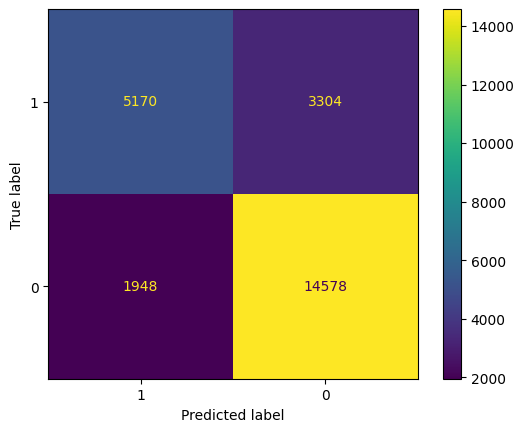

In [216]:
svc_confusion = confusion_matrix(y_pred=svc_pred, y_true=higgs_labels )
ConfusionMatrixDisplay.from_predictions(
    y_true=higgs_labels,
    y_pred=svc_pred,
    labels=[1,0]
)

print(svc_confusion)


In [217]:
_=get_and_print_confusion_analisis(svc_confusion, True)

ACC: 78.99199999999999
Recall: 0.6101014869011093
precision: 0.7263276201180107
TP: 5170
TN: 14578
FN: 3304
FP: 1948


Se ve que tiene mucho mejor FP pero peor FN, lo que empeora el recall, y mejora la precisión bastante, lo cual se diferencia del árbol de decisión. Esto se puede deber a que le puse pesos al árbol a favor de la clase positiva